Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your github nickname below:

In [1]:
NICKNAME = "underham2ter"
import scipy.special, scipy.integrate
import numpy as np
import sys
from scipy.linalg import solve as ls
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,8)
import seaborn as sns
sns.set(font_scale=1, rc={'text.usetex' : True})
sns.set_palette(sns.color_palette("hls", 8))

# Часть 1. Гауссовы квадратуры

Метод Гауссовых квадратур является одним из методов численного интегрирования, который позволяет увеличить точность интегрирования, используя ортогональные полиномы и их корни в качестве узлов.

$$
\int_a^b \!  w(x)\, f(x)\, dx \approx \sum_{k=1}^n w_k \, f(x_k) \;,
$$

здесь $\omega$ - функция весов, которая определят базис ортогональных полиномов, чьи корни используются в качестве узлов интегрирования. 

Получаемая таким образом квадратурная схема *точно* инегрирует $f(x)$ если это полином степени $m\le2n-1$, где $n$ - степень полинома, корни которого используются в качестве узлов.

## Двухточечная квадратура Гаусса

Постройте квадратурную формулу Гаусса, интегрирующую точно многочлены степеней вплоть до третьей на интервале $[a, b]$. Заметим, что для этого достаточно построить _двухточечную_ квадратуру.

    hint:Легко найти точки и веса для отрезка [-1,1], после чего можно сделать аффинное преобразование..

Напишите функцию, которая возвращает веса, $w_1$ и $w_2$, и узлы, $x_1$ и $x_2$, двухточечной квадратурной формулы Гаусса с весовой функцией $w(x) = 1$, т.е., интегралы вида

$$\int_a^b\! f(x)\, dx \approx w_1 f(x_1) + w_2 f(x_2)$$

In [2]:
def gauss_2(a, b):
    r"""Return nodes and weights for a two-point Gauss quadrature on [a, b].
    
    Parameters
    ----------
    a, b : float
       Boundaries of the integration interval
       
    Returns
    -------
    x1, x2, w1, w2 : float
       Nodes and weights of the quadrature.
    """
    nodes, weights = scipy.special.roots_legendre(2)
    x1 = (a+b)/2+(b-a)/2 * nodes[0]
    x2 = (a+b)/2+(b-a)/2 * nodes[1]
    w1 = (b-a)/2 * weights[0]
    w2 = (b-a)/2 * weights[1]
    return x1, x2, w1, w2

In [3]:
from numpy.testing import assert_allclose

x1, x2, w1, w2 = gauss_2(0, 1)

def f(x, n): 
    return x**n

for n in [0, 1, 2, 3]:
    assert_allclose(w1*f(x1, n=n) + w2*f(x2, n=n),
                    1./(n+1), atol=1e-14)

## Использование ортогональных полиномов

### Legendre

Теперь посчитаем следующий интеграл:

$$\int_{-1}^1 (7x^3 - 8 x^2 - 3 x + 3) dx  \label{eq1}\tag{1}$$

Здесь функция уже полиномиальна, поэтому возьмем весовую функцию $\omega(x) = 1$. Тогда вычисление интеграла сводится к сумме корней полинома, соответствующих весовой функции $\omega(x) = 1$. Например, здесь https://dlmf.nist.gov/18.3 вы можете увидеть, какой базис полиномов соответствует вашей весовой функции.

Заметим, что нашей соответствуют полиномы Лежандра. Теперь, зайдем в документацию https://docs.scipy.org/doc/scipy/reference/special.html#orthogonal-polynomials. Функция *roots_legendre* сразу же выдаст корни полиномов Лежандра, а также веса к их корням (для полиномов Лежандра все эти веса равны единице).

1. Посчитайте точное значение интеграла ([1](#mjx-eqn-eq1)) "руками".

In [4]:
a = -1
b = 1
func = lambda x: 7*x**3-8*x**2-3*x+3
Func = lambda x: 7/4*x**4-8/3*x**3-3/2*x**2+3*x
print(Func(b)-Func(a))

0.6666666666666674


2. Посчитайте значение интеграла ([1](#mjx-eqn-eq1)), используя обычный метод интегрирования на равномерной сетке (например, написанный вами в предыдущем дз). Оцените количество узлов, необходимых для достижения относительной точности $10^{-10}$.

In [5]:
def midpoint_rule(func, a, b, nseg):
    """Обобщённое правило прямоугольников."""
    dx = (b - a) / nseg
    sum = 0.0
    xstart = a + 0.5 * dx
    for i in range(nseg):
        sum += func(xstart + i * dx)

    return sum * dx

def trapezoid_rule(func, a, b, rtol = 1e-8):
    """
    Правило трапеций
    rtol - желаемая относительная точность вычислений
    """
    nseg = 1
    dx = (b - a) / nseg
    ans = 0.5 * dx * (func(a) + func(b))
    err_est = 1
    while err_est > abs(rtol * ans):
        old_ans = ans
        ans = 0.5 * (ans + midpoint_rule(func, a, b, nseg))
        nseg *= 2
        err_est = abs(ans - old_ans)
    return ans, nseg

Q, N = trapezoid_rule(func, a, b, rtol=1e-10)
print(Q, N)

0.6666666666569454 1048576


3. Посчитайте значение интеграла ([1](#mjx-eqn-eq1)), с помощью Гауссовой квадратуры (используя корни полинома Лежандра степени от 1 до 6 в качестве узлов) (чтобы получить корни и веса используйте scipy.special.roots_legendre)

In [6]:
for n in range(1,7):
    nodes, weights = scipy.special.roots_legendre(n)

    print((func(nodes) * weights).sum())

6.0
0.6666666666666674
0.6666666666666639
0.6666666666666667
0.6666666666666685
0.6666666666666695


Сравните количество узлов, необходимых для достижения одинаковой точности в обоих чисенных методах.

In [7]:
def legendre_eps(func, rtol):
    i_approx, n, i_exact = 10, 0, 2/3
    while abs(i_approx-i_exact)>i_exact*rtol:
            n += 1
            nodes, weights = scipy.special.roots_legendre(n)
            i_approx=(func(nodes) * weights).sum()

    return i_approx, n

    print((func(nodes) * weights).sum())
for i in range(5, 13):
    eps = 10**(-i)
    _, N1 = legendre_eps(func, eps)
    _, N2 = trapezoid_rule(func, a, b, rtol=eps)
    print(eps, N1, N2)

1e-05 2 4096
1e-06 2 8192
1e-07 2 32768
1e-08 2 131072
1e-09 2 262144
1e-10 2 1048576
1e-11 2 4194304
1e-12 2 8388608



Вычислите значение того же интеграла, но на интервале от 0 до 10.

$$\int_{0}^{10} (7x^3 - 8 x^2 - 3 x + 3) dx $$

Заметим, что больше нельзя использовать полиномы Лежанда, потому что они определены на интервале (-1, 1). Однако всегда можно произвести *аффинное преобразование* для того, чтобы перейти к желаемой системе координат.

(20% итоговой оценки)

In [8]:
f_y = lambda y: 10*(7000*y**3-800*y**2-30*y+3)
nodes, weights = scipy.special.roots_sh_legendre(6)
I_exact = 44140/3
I_approx = (f_y(nodes) * weights).sum()
print('I_approx = %s' % I_approx)
print('Error = %s' %  abs(I_exact-I_approx))

I_approx = 14713.33333333333
Error = 3.637978807091713e-12


Сравните результат с точным значением интеграла.

$\int_{0}^{10} (7x^3 - 8 x^2 - 3 x + 3) dx =\{y = \frac{x}{10}\}= \int_{0}^{1} 10\cdot (7000y^3 - 800y^2 - 30y + 3) dy$

Можем использовать смещенный полином Лежандра

$I_{exact} = \frac{44140}{3} = 14713.\overline 3$, что супер близко к $I_{approx}$

### 

Вычислите значение следующиего интеграла:
$
\int_{0}^{2\pi}\frac{cos(x) dx }{\sqrt{4\pi^2 - x^2}}
$
используя соответствующий базис ортогональных полиномов.
Найдите степень полинома (количество узлов), при которой точность превысит машинное $\epsilon$.

$\int_{0}^{2\pi}\frac{cos(x) dx }{\sqrt{4\pi^2 - x^2}}=\{x = 2\pi y\}=
\int_{0}^{1}\frac{cos(2\pi y) dy }{\sqrt{1 - y^2}}=\frac{1}{2}\int_{-1}^{1}\frac{cos(2\pi y) dy }{\sqrt{1 - y^2}}
$

Делаем по полиному Чебышева первого рода.

In [9]:
I_exact = 0.34601015881226444
I_approx = 1
funcy = lambda y: 1/2*np.cos(2*np.pi*y)
n = 0
while abs(I_approx-I_exact) != 0:
    n += 1
    nodes, weights = scipy.special.roots_chebyt(n)

    I_approx = (funcy(nodes) * weights).sum()


print(n)

17


# Часть 2. Уравение Фредгольма

Существует два типа уравнений Фредгольма: 

1. Уравение Фредгольма первого рода:
$$\int_a^b \! K(x, t)\, \color{blue}{f(t)} \,dt = g(x)$$

2. Уравнение Фредгольма второго рода:
$$\lambda \int_a^b\! K(x, t)\, \color{blue}{f(t)} \, dt + g(x) = \color{blue}{f(x)}$$

Здесь функция $f(x)$ неизвестна, $K(x, t)$ - ядро уравнения, заданная функция $g(x)$ и $\lambda$ - рациональное число.
С точки зрения вычислений, уравение Фредгольма первого рода крайне неустойчиво. Далее мы рассмотрим только уравнение второго рода.

Основная идея - аппроксимировать интеграл некой квадратурной формулой

$$
\int_a^b \! \xi(t)\, dt \approx \sum_j^N w_j\, \xi(t_j)
$$

с подходящими весами $w_j$ и узлами $t_j$, $j=1, \dots, N$. Точность аппроксимации контролируется $N$.

Таким образом, уравнение Фредгольма приближается следующим образом:

$$\lambda \sum_j w_j\, K(x, t_j)\, \color{blue}{f(t_j)} + g(x) = \color{blue}{f(x)}$$

Отметим, что $x$ - непрерывная переменная, в то время, как $t$ - дискретная.

Рассматривая данное уравнение на тех же узлах сетки $x = t_k$, получаем

$$\lambda \sum_j w_j \, K_{k, j}\, \color{blue}{f_j} + g_k = \color{blue}{f_k}$$

где $f_j \equiv f(t_j)$, $g_j \equiv g(t_j)$ and $K_{k, j} \equiv K(t_k, t_j)$. Это ничто иное, как система линейных алгебраических уравнений на вектор $\color{blue}{f_j}$.

Ее решение выдает значение неизвестной функции $f(x)$ в дискретных точках $x=t_j$ для $j=1, \dots, N$.


Решите предложенное уравнение Фредгольма второго рода

$$f(x) = \cos(x)  + \frac{1}{2\pi} \int_0^\pi \! \sin(x) \,t f(t) \, dt$$

Здесь $a, b = 0, 1$, $\lambda = \dfrac{1}{2\pi}$, ядро $K(x, t) = \sin(x)\cdot t$ и правая часть - $g(x) = \cos(x)$.

Точное решение (Сборник задач по интегральным уравнениям, 2006):

$$f(x) = \cos(x)- \frac{2}{\pi}\sin(x)$$

Для нахождения интеграла преобразуйте заменой переменных в интеграле область интегрирования в [0,1] воспользуйтесь Гауссовой квадратурой с весовой функцией $w(x) = 1$ на $(0, 1)$. Посмотрите на http://dlmf.nist.gov/18.3, и найдите соответствующую функцию в *scipy.special* (обратите внимание на область интегрирования).

Напишите функцию, возвращающую значение f(t_j) по схеме выше, которая в качестве параметра принимает величину $N$--число узлов в квадратуре, для нахождение решения СЛАУ можно использовать `scipy.linalg.solve`.

Постройте график истинного решения и набор (t_j, f_j) для раличных $N$, используя вашу функцию.

Экономия времени ради не буду приводить теоритические выкладки..

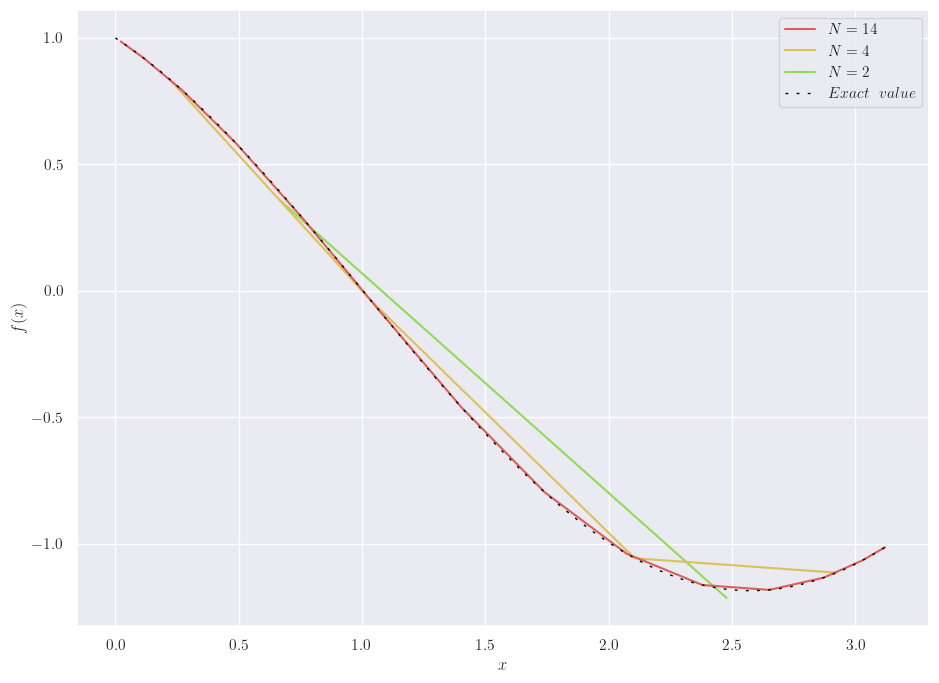

In [15]:
def f_at_roots(N):
    roots, weights = scipy.special.roots_sh_legendre(N)
    I_ = np.eye(N)

    K = np.vectorize(lambda x, t: np.sin(np.pi * x) * t)
    K_ = np.pi * 0.5 * np.array([weights * K(t, roots) for t in roots]) - I_

    g = lambda x: np.cos(np.pi * x)
    g_ = - g(roots)

    f_ = ls(K_, g_)

    return f_, roots, weights

fr = lambda x: np.cos(x) - (2/np.pi) * np.sin(x)
x_lin = np.linspace(0, np.pi, 69)

N_ = [14, 4, 2]
for N in N_:

    f_, roots, _ = f_at_roots(N)
    x = roots * np.pi
    plt.plot(x, f_, label=('$N = %s$' % N), zorder=N, linewidth=1.5)

plt.plot(x_lin, fr(x_lin), '--', dashes=(2,6), linewidth=1, zorder=20, alpha=1, label='$Exact~~value$', color='black')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend()
plt.show()

Очевидной проблемой предыдущего результата для $f(x)$ является то, что он возвращает решения на фиксированном наборе точек. Мы не контролируем их расположение.

Оказывается, интерполяционные методы (мы обсудим их на следующих занятиях) работают не очень хорошо, в сравнении с следующим подходом:

Используйте изначальный вид, чтобы вычислить значение функции на всём интервале:

$$f(x) = g(x) + \lambda \sum_j^N w_j\, K(x, t_j)\, f(t_j)$$

Сравните эту интерполяцию с точным решением для разлиных $N$.
(выбирайте наглядный масштаб)

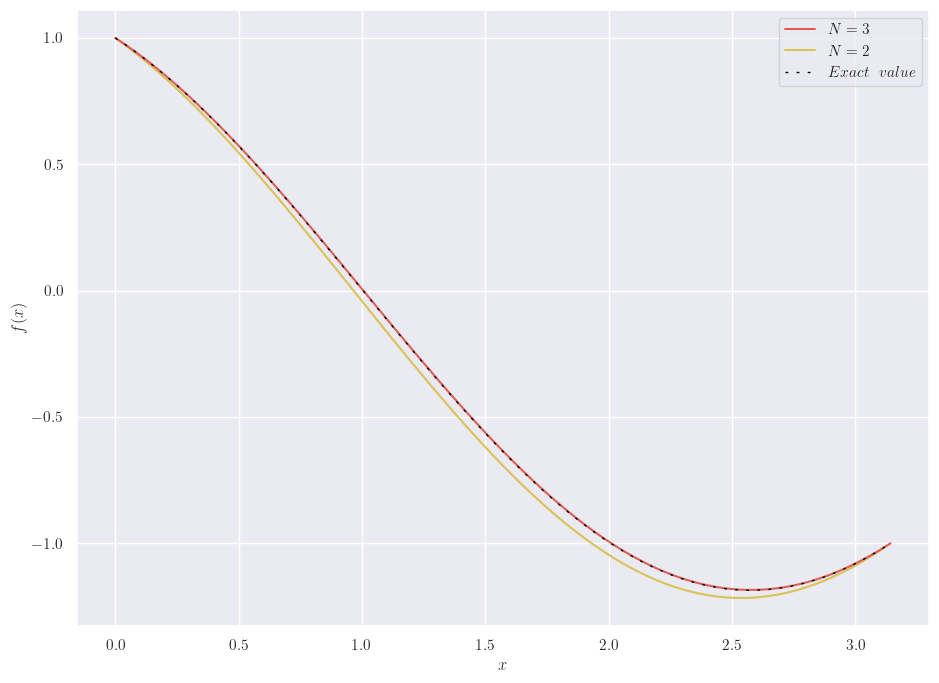

In [16]:
x_lin = np.linspace(0, np.pi, 77)
K = np.vectorize(lambda x, t: np.sin(np.pi * x) * t)
g = lambda x: np.cos(np.pi * x)

N_ = [3, 2]
for N in N_:
    f_unity, roots, weights = f_at_roots(N)

    func = lambda x: g(x) + 0.5 * np.pi * (weights * K(x, roots) * f_unity).sum()
    f_lin = np.array([func(x) for x in x_lin/np.pi])
    plt.plot(x_lin, f_lin, label=('$N = %s$' % N), zorder=N, linewidth=1.5)

fr = lambda x: np.cos(x) - (2 / np.pi) * np.sin(x)


plt.plot(x_lin, fr(x_lin), '--', dashes=(2,6), linewidth=1, zorder=20, alpha=1, label='$Exact~~value$', color='black')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend()
plt.show()

# Часть 3. Интеграл от осциллирующей функции - EXTRA points task

Рассмотрим определенный интеграл

$$I = \int_0^\infty\! \frac{\sin(x) \cos{(\cos{(x)})}}{x}\,dx$$

Вычислите значение данного интеграла с относительной точностью $10^{-6}$. Для упрощения задачи можете воспользоваться функционалом `scipy.integrate.quad`.

Заметим, что "из коробки" интеграл вычислить не удается, и нужно что-то придумать.

In [12]:
from math import sin, cos

from scipy.integrate import quad
quad(lambda x: sin(x) * cos(cos(x)) / x, 0, float('inf'))

C:\Users\alexv\AppData\Local\Temp\ipykernel_14108\1421360106.py:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad(lambda x: sin(x) * cos(cos(x)) / x, 0, float('inf'))


(1.9653912540956733, 4.089174284042322)

Напишите функцию, которая возвращает значение данного интеграла. Только само значение интеграла, без оценки погрешности.
(оборачиваем интеграл в функцию только для удобства автопроверки).

In [13]:
from scipy.integrate import quad

def integ():
    """Return a single float, the computed value of the integral."""
    # YOUR CODE HERE


In [14]:
from numpy.testing import assert_allclose

# this is a test cell, keep it intact
